In [1]:
# load the black code formatter for jupyter lab
%load_ext lab_black

This very simple notebook will take a blood pressure reading log (the provided example data is produced by an OMRON Smart X reader), allocate the readings to three sections of the day (AM, MID and PM) and draw a boxplot to perform a first rough estimate about the presence of a trend. Then plot the measurements in time to give an idea of the trend.

Import needed libraries

In [2]:
# One ring to handle numbers
import pandas as pd
import scipy.stats as stats

# One ring to handle time
import datetime as dt
from datetime import date
import time

# One ring to draw reality
import seaborn as sns
import matplotlib.pyplot as plt

# and One ring to rule them all ;)
# from matplotlib.dates import date2num

Set the (arbitrary) limits to divide the day in an AM, MID(day) and PM areas and the name of data file

In [3]:
AM_LIMIT = 10
PM_LIMIT = 16
LOGNAME = "data/new_bp_log.csv"
# LOGNAME = '../input/blood-pressure-readings/bp_log.csv' # on Kaggle
# https://www.kaggle.com/rjalexander/blood-pressure-circadian

Define a function to generate a "partofday" categorical label based on the hour of the blood pressure reading and the limits we set above

In [4]:
def partofday(hour):
    if hour <= AM_LIMIT:
        return "AM"
    elif hour > AM_LIMIT and hour <= PM_LIMIT:
        return "MID"
    else:
        return "PM"

Read and take a peek at the data as read in a dataframe

In [5]:
df = pd.read_csv(LOGNAME)

In [6]:
# recreate a Measurement Date text field field like in the old log format to reuse older code
df["Measurement Date"] = df["Date"] + " " + df["Time"]
# also rename the systolic (SYS) and diastolic (DIA) and pulse (Pulse) columns with the old log format names
df.rename(
    columns={
        "Systolic (mmHg)": "SYS",
        "Diastolic (mmHg)": "DIA",
        "Pulse (bpm)": "Pulse",
    },
    inplace=True,
)

Add a new "partofday" categorical new column in the dataframe

In [7]:
df["partofday"] = df.apply(
    lambda row: partofday(pd.to_datetime(row["Measurement Date"]).hour), axis=1
)

### Add a datetime column and a couple of derived ordinals


In [8]:
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"]
)  # generate a datetime object from the two Date and Time strings
df["unix"] = (
    df["datetime"].astype("int64") / 1e9
)  # generate seconds from Unix epoch from the datetime object
df["elapsed_seconds"] = (
    df["datetime"] - df["datetime"].min()
).dt.total_seconds()  # generate seconds from earliest observation time
df.sample(5)

,Date,Time,SYS,DIA,Pulse,Irregular heartbeat detected,Body Movement,Cuff wrap guide,Positioning Indicator,Measurement Mode,Possible Afib,Device,Notes,Measurement Date,partofday,datetime,unix,elapsed_seconds
35,05 Jul 2021,10:22,122,81,67,,,,,,,HEM-7361T_ESL,_,05 Jul 2021 10:22,AM,2021-07-05 10:22:00,1.625481e+09,5095080.0
51,20 Jul 2021,11:42,129,82,69,,,,,,,HEM-7361T_ESL,_,20 Jul 2021 11:42,MID,2021-07-20 11:42:00,1.626781e+09,6395880.0
42,15 Jul 2021,13:53,128,82,68,,,,,,,HEM-7361T_ESL,_,15 Jul 2021 13:53,MID,2021-07-15 13:53:00,1.626357e+09,5971740.0
4,28 Jun 2022,10:02,107,69,72,,,Not OK,,,,X7 Smart,-,28 Jun 2022 10:02,AM,2022-06-28 10:02:00,1.656411e+09,36025080.0
48,18 Jul 2021,11:05,126,83,63,,,,,,,HEM-7361T_ESL,_,18 Jul 2021 11:05,MID,2021-07-18 11:05:00,1.626606e+09,6220860.0


Now plot the SYS(tolic) and then the DIA(stolic) pressure values divided in the three sections of the day

In [9]:
sns.set_theme(style="whitegrid")

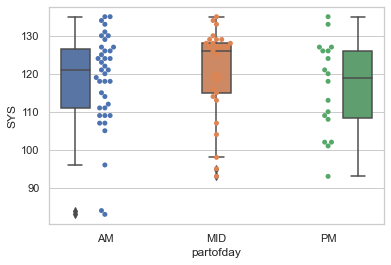

In [10]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["SYS"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

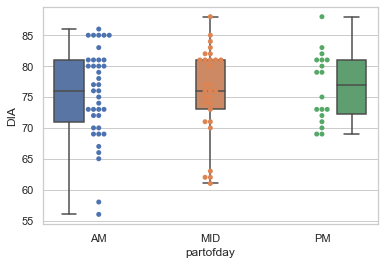

In [11]:
ax = sns.boxplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax = sns.swarmplot(
    x=df["partofday"],
    y=df["DIA"],
    hue=df["partofday"],
    data=df,
    order=["AM", "MID", "PM"],
)
ax.legend_.remove()

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and PM

In [12]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "PM"])

Ttest_indResult(statistic=0.5326811355868639, pvalue=0.5964000356653514)

In [13]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "PM"])

Ttest_indResult(statistic=-0.5631900952971619, pvalue=0.5755943460388817)

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and MIDday

In [14]:
stats.ttest_ind(df["SYS"][df["partofday"] == "AM"], df["SYS"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.741394074718634, pvalue=0.4610845062608159)

In [15]:
stats.ttest_ind(df["DIA"][df["partofday"] == "AM"], df["DIA"][df["partofday"] == "MID"])

Ttest_indResult(statistic=-0.23469737040226216, pvalue=0.8151702325005526)

### Conclusion: no significant distribution variability of blood presure values between the three daily phases 

### Let's now plot the BP values and see what's their temporal trend in time

Now plot a scatterplot with a linear regression fit. To do so as the scattterplot does not accept a datetime timestamp as the x values, I am using the epoch (seconds from 01-jan-1970) contained in the "unix" column

In [57]:
def regplot_of_df(df):
    plt.figure(figsize=(44, 16))
    ax = sns.regplot(x="unix", y="SYS", data=df, label="SYS", scatter_kws={"s": 100})
    ax = sns.regplot(x="unix", y="DIA", data=df, label="DIA", scatter_kws={"s": 100})
    # create some whitespace horizontally around the plot values
    ax.set_xlim(df["unix"].min() - 100000, df["unix"].max() + 100000)
    # now convert the epoch values back to a YYYY-MM-DD string for the x labels
    # localtime converts the epoch into a datetime object abd strftime converts it into a string
    new_labels = [
        time.strftime("%Y-%m-%d", time.localtime(item)) for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels)
    # set some visuals
    ax.set_xlabel("Measurement Date", fontsize=28, labelpad=20)
    ax.set_ylabel("Arm cuff BP (mmHg)", fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.legend(prop={"size": 20})
    plt.show()

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_91136/2508877996.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


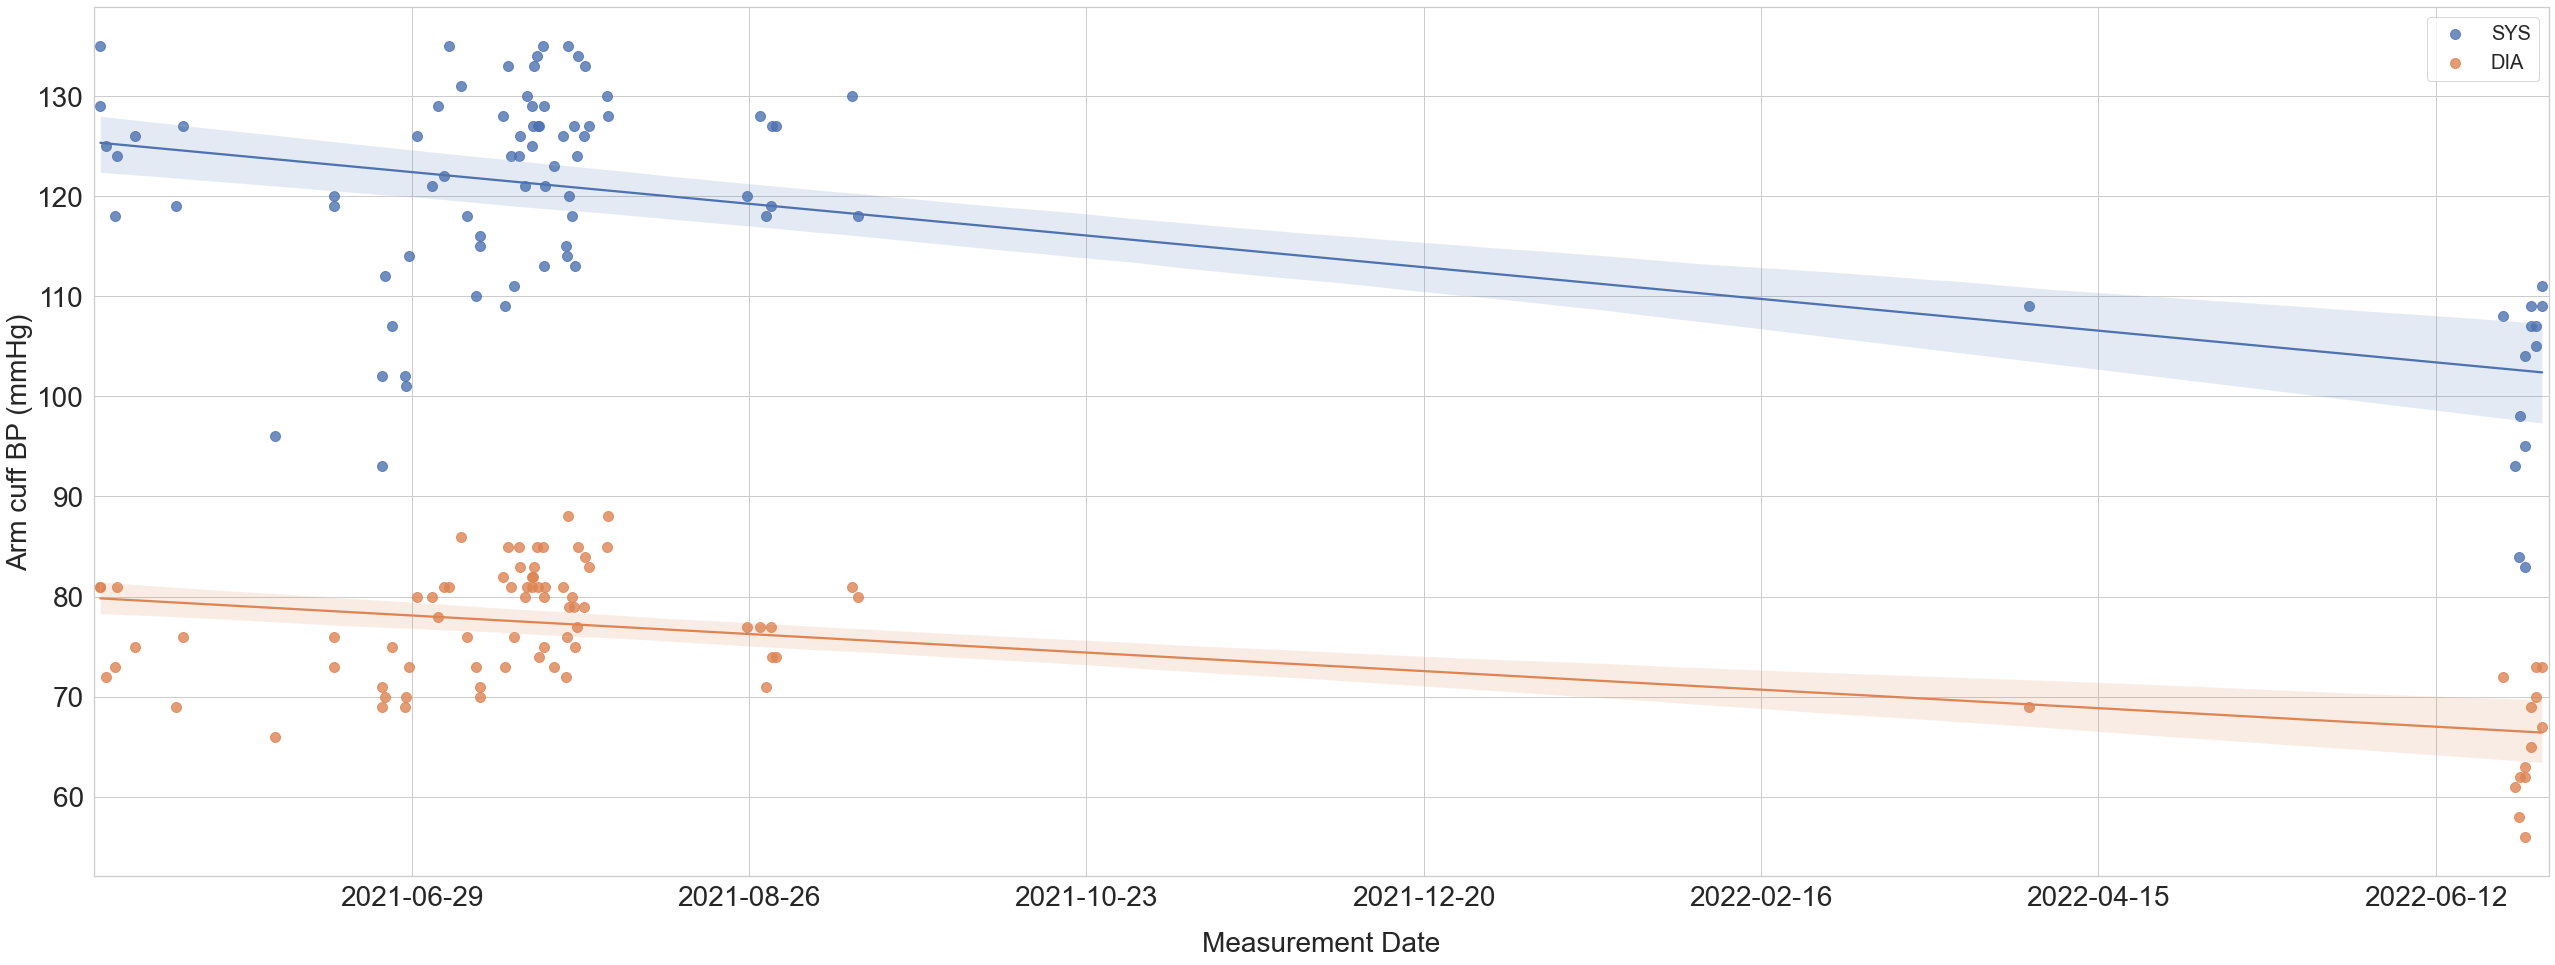

In [58]:
regplot_of_df(df)

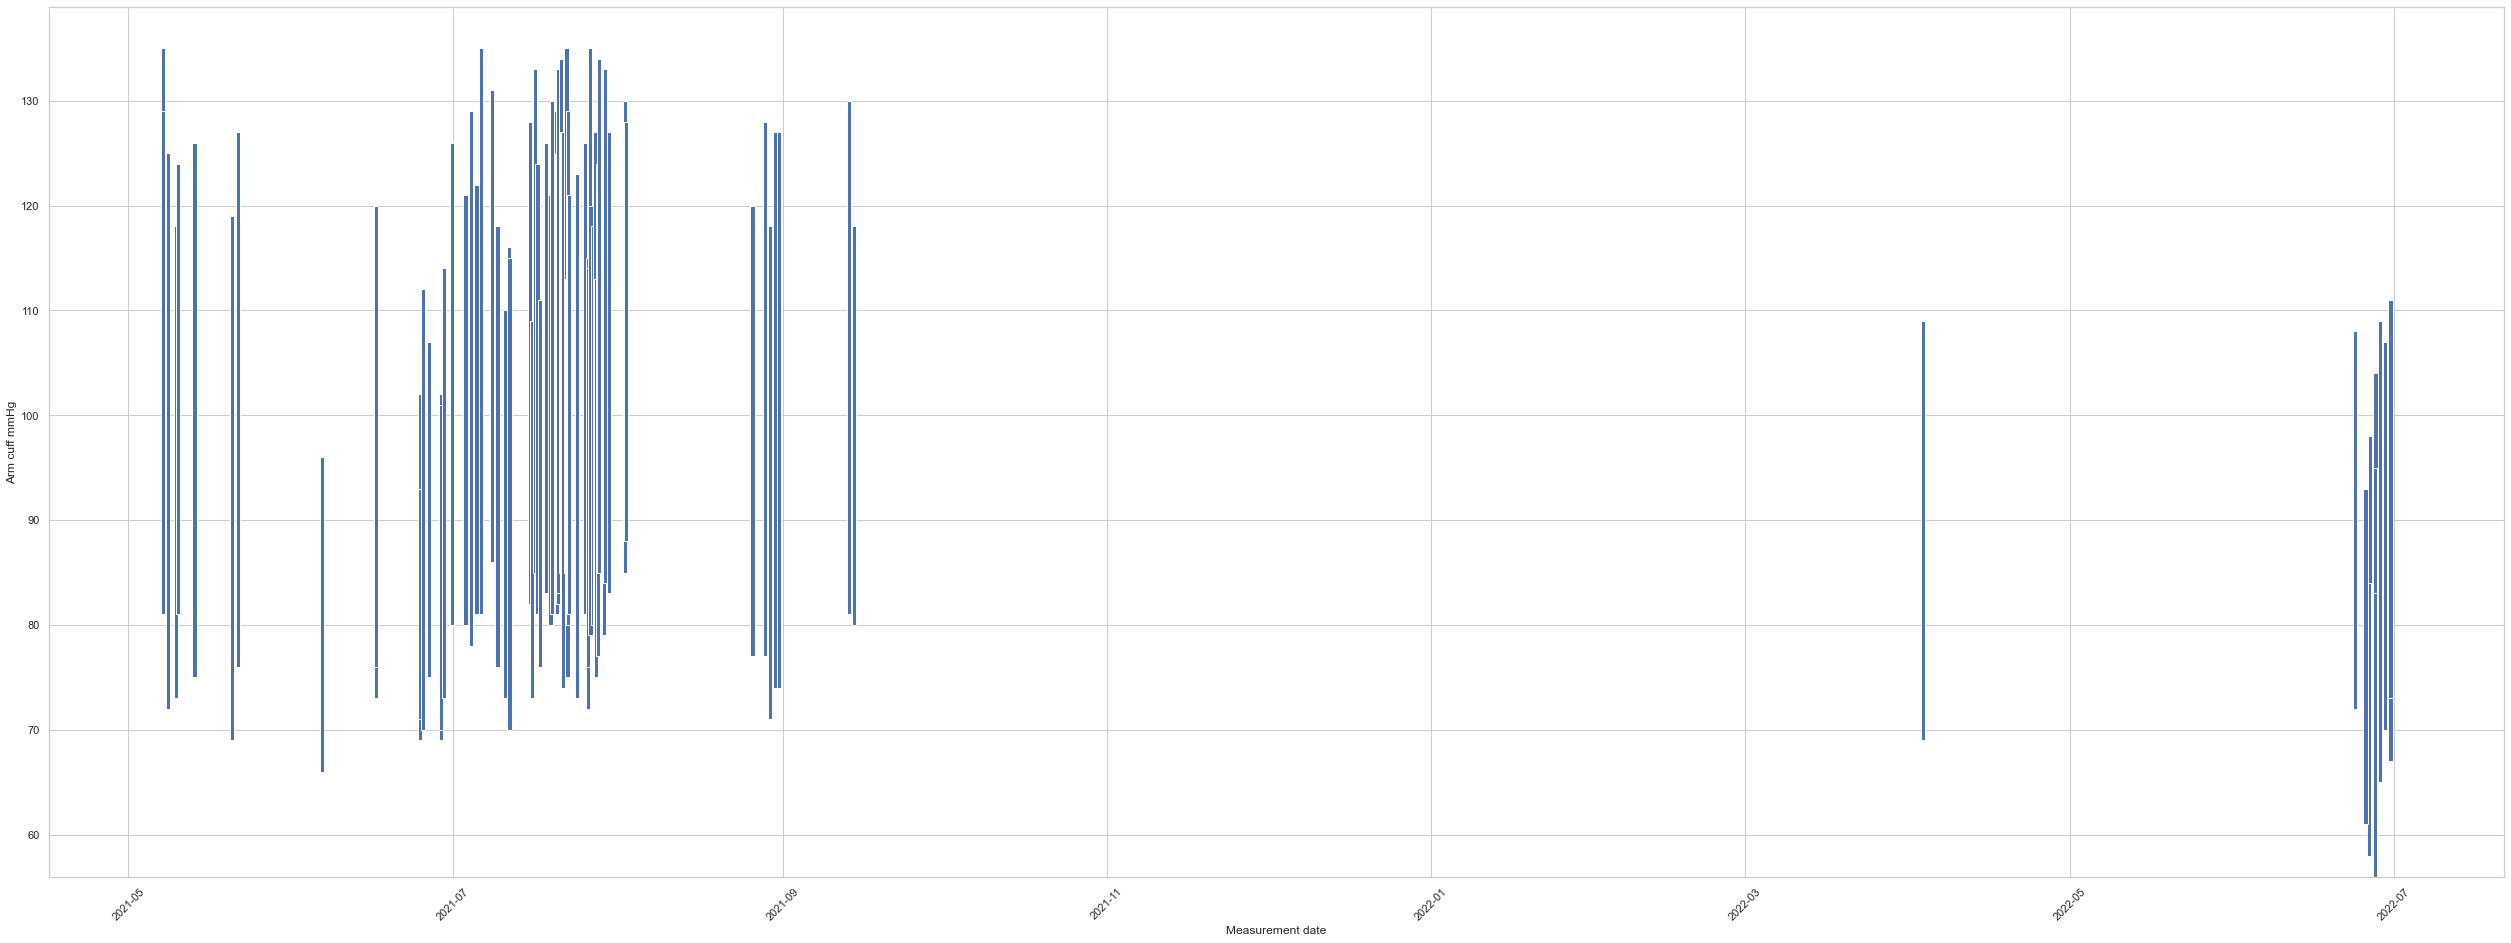

In [59]:
plt.figure(figsize=(44, 16))
plt.bar(
    x=df["datetime"],
    height=df["SYS"] - df["DIA"],
    bottom=df["DIA"],
    width=0.8,
)
plt.xticks(rotation=45)
plt.xlabel("Measurement date")
plt.ylabel("Arm cuff mmHg")
plt.show()

In [60]:
df_simple = df[["datetime", "SYS", "DIA", "unix"]]

In [61]:
today = date.today()
week_prior = today - dt.timedelta(weeks=1)
month_prior = today - dt.timedelta(days=30)
df_lastweek = df_simple[df_simple["datetime"].dt.date >= week_prior]
df_lastmonth = df_simple[df_simple["datetime"].dt.date >= month_prior]

# Now describe last week measurements if available

In [62]:
df_lastweek.describe()

,SYS,DIA,unix
count,13.000000,13.000000,1.300000e+01
mean,101.000000,65.461538,1.656354e+09
std,9.556847,5.680601,1.650392e+05
min,83.000000,56.000000,1.656005e+09
25%,95.000000,62.000000,1.656247e+09
50%,105.000000,65.000000,1.656332e+09
75%,108.000000,70.000000,1.656490e+09
max,111.000000,73.000000,1.656579e+09


/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_91136/2508877996.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


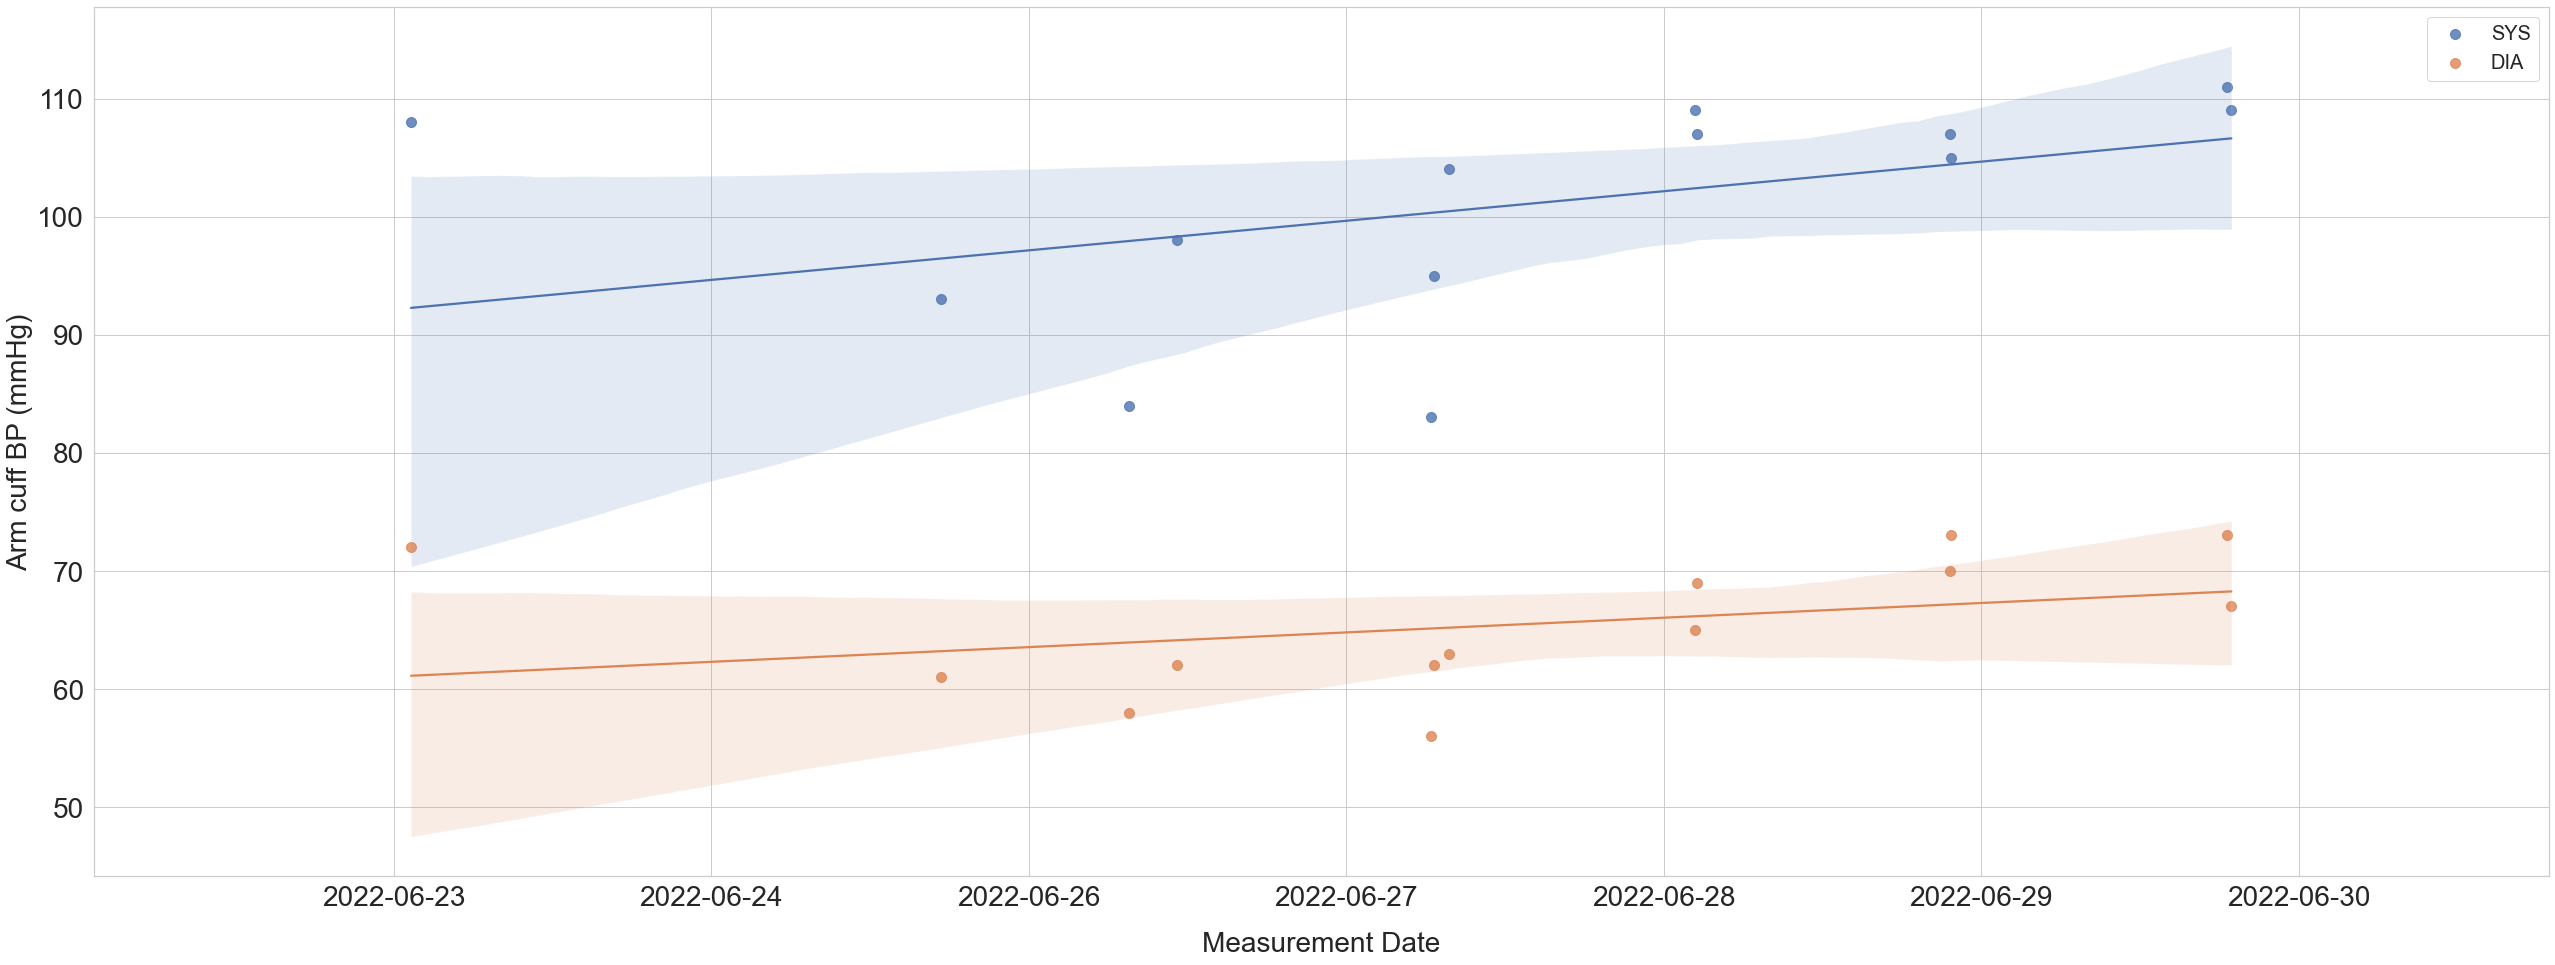

In [63]:
regplot_of_df(df_lastweek)

# Now describe last 30 days measurements (if different from last week)

In [64]:
if not df_lastweek.equals(df_lastmonth):
    df_lastmonth.describe()

In [65]:
if not df_lastweek.equals(df_lastmonth):
    regplot_of_df(df_lastmonth)